# Fashion MNIST

## Importing required packages

In [1]:
import torch 
from torchvision import transforms,datasets
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt 
import numpy as np 


## Defining our Transforms

In [2]:
transform=transforms.ToTensor()

## Gathering the train and test data


In [3]:
train_data=datasets.FashionMNIST('data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST('data',train=False,download=True,transform=transform)

## Defining our Train, Valid and Test Dataloaders

In [4]:
valid_size=0.2
train_length=len(train_data)

indices=[i for i in range(train_length)]
np.random.shuffle(indices)

split=int(np.floor(valid_size*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]


train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

num_workers=0
batch_size=20
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

# This is for debugging
print(f"Training data size : {train_idx.__len__()}, Validation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


In [5]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch


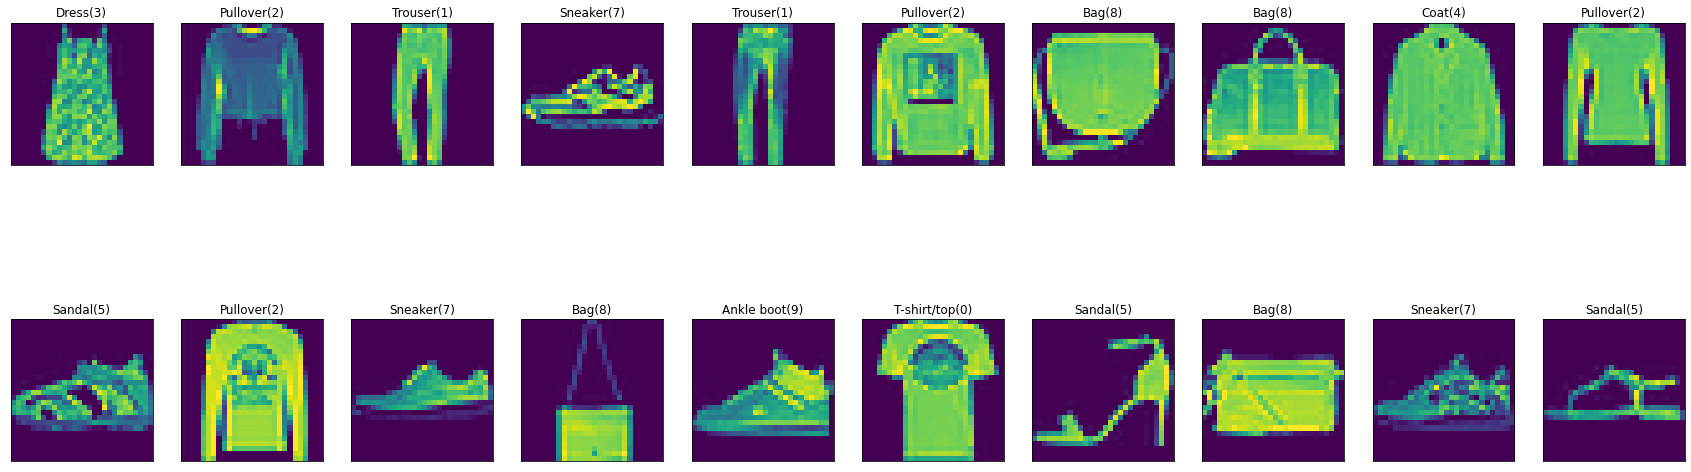

In [6]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(f"{fashion_class[labels[i].item()]}({labels[i].item()})")
    

## Defining our Neural Net Architecture

In [7]:
"""
 This model has dropout set to a certain value
 NOTE : 
 When we want to use dropout we ensure we run .train() method on our model ---> during training phase
 If not required we should use .eval() method ---> during validation and testing phase
 """
class fashionMNIST(nn.Module):
    def __init__(self):
        super(fashionMNIST,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
    
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x=x.view(-1,28*28)
        x=self.dropout(torch.sigmoid(self.fc1(x)))
        x=self.dropout(torch.sigmoid(self.fc2(x)))
        x=self.out(x)
        return x


In [8]:
model=fashionMNIST()
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model.cuda()
print(f"Our Model : {model}, GPU Available : {torch.cuda.is_available()}")

Our Model : fashionMNIST(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
), GPU Available : False


## Defining our Loss Function and Optimizer


In [9]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

# Learning Rate
lr=0.001
# Optimizer 
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

## Training and Validation Phase


In [10]:
# Number of epochs to train for
loss_keeper={'train':[],'valid':[]}
epochs=50

# minimum validation loss ----- set initial minimum to infinity
valid_loss_min = np.Inf 

for epoch in range(epochs):
  train_loss=0.0
  valid_loss=0.0

  """
  TRAINING PHASE
  """
  model.train() # TURN ON DROPOUT for training
  for images,labels in train_loader:
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    optimizer.zero_grad()
    output=model(images)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()*images.size(0)

  """
  VALIDATION PHASE
  """
  model.eval() # TURN OFF DROPOUT for validation
  for images,labels in valid_loader:
    output=model(images)
    loss=criterion(output,labels)
    valid_loss+=loss.item()*images.size(0)

  # Calculating loss over entire batch size for every epoch
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)


  # saving loss values
  loss_keeper['train'].append(train_loss)
  loss_keeper['valid'].append(valid_loss)

  print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
  if valid_loss<=valid_loss_min:
    print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min=valid_loss



Epoch : 1	Training Loss : 0.46187396608044706	Validation Loss : 0.316173149296393
Validation loss decreased from : inf ----> 0.316173149296393 ----> Saving Model.......

Epoch : 2	Training Loss : 0.31920650494719544	Validation Loss : 0.29954065470397473
Validation loss decreased from : 0.316173149296393 ----> 0.29954065470397473 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2889438388086855	Validation Loss : 0.2570636335536838
Validation loss decreased from : 0.29954065470397473 ----> 0.2570636335536838 ----> Saving Model.......

Epoch : 4	Training Loss : 0.26727829754849275	Validation Loss : 0.23925629321299494
Validation loss decreased from : 0.2570636335536838 ----> 0.23925629321299494 ----> Saving Model.......

Epoch : 5	Training Loss : 0.2538006573440507	Validation Loss : 0.21837892374272147
Validation loss decreased from : 0.23925629321299494 ----> 0.21837892374272147 ----> Saving Model.......

Epoch : 6	Training Loss : 0.24180174787777164	Validation Loss : 0.2149406882

## Loading model from Lowest Validation Loss


In [11]:
model.load_state_dict(torch.load('model.pt'))
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.3088,  0.5272,  1.0210,  ..., -0.2234, -0.4672,  0.2548],
                      [-0.0263, -0.1195, -0.5484,  ...,  0.1847,  0.5477,  0.5475],
                      [ 0.3450,  0.8009,  0.0682,  ...,  0.0461,  0.6242,  0.6340],
                      ...,
                      [-0.0642, -0.2911, -0.7486,  ..., -0.2390, -0.4866, -0.5130],
                      [-0.0559, -0.1691, -0.6804,  ...,  0.1252,  0.4289,  0.6945],
                      [-0.0351,  0.4501, -0.9753,  ...,  0.3501,  0.9792,  0.5926]])),
             ('fc1.bias',
              tensor([-1.1414e-02, -3.6804e-01, -8.2842e-02, -1.4725e+00,  5.0545e-01,
                      -6.7849e-01, -3.2664e-01, -4.7884e-01, -7.0935e-01,  2.1237e-01,
                      -2.0847e-01, -9.9238e-02, -2.9469e-01,  3.0821e-03,  5.7603e-01,
                      -7.5852e-01, -1.0792e-01, -1.7040e-01,  1.6036e-01,  2.9918e-01,
                      -5.1309e-01, -9.3257e-02, -1.2489e-01,  7.

## Plotting Training and Validation Losses


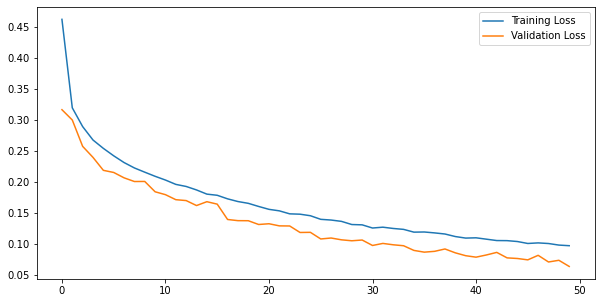

In [12]:
plt.figure(1,figsize=(10,5))
plt.plot(loss_keeper['train'],label="Training Loss");
plt.plot(loss_keeper['valid'],label="Validation Loss");
plt.legend();

## Testing Phase


In [13]:
correct=0
test_loss=0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # test the model with dropout layers off
for images,labels in test_loader:
    output=model(images)
    loss=criterion(output,labels)
    test_loss+=loss.item()
    _,pred=torch.max(output,1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss=test_loss/len(test_loader)

print(f"Test Loss : {test_loss}")
print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {int(sum(class_correct))}")
print(f"Total Predictions per class : {class_total}, Total predictions to be made : {int(sum(class_total))}")

for i in range(10):
    if class_total[i] > 0:
        print(f"\nTest Accuracy of class {i} : {int(100 * class_correct[i] / class_total[i])}% where {int(class_correct[i])} of {int(class_total[i])} were predicted correctly")


print(f"\nOverall Test Accuracy : {int(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    

Test Loss : 0.4004178969454342
Correctly predicted per class : [878.0, 977.0, 846.0, 912.0, 845.0, 972.0, 660.0, 958.0, 981.0, 963.0], Total correctly perdicted : 8992
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000

Test Accuracy of class 0 : 87% where 878 of 1000 were predicted correctly

Test Accuracy of class 1 : 97% where 977 of 1000 were predicted correctly

Test Accuracy of class 2 : 84% where 846 of 1000 were predicted correctly

Test Accuracy of class 3 : 91% where 912 of 1000 were predicted correctly

Test Accuracy of class 4 : 84% where 845 of 1000 were predicted correctly

Test Accuracy of class 5 : 97% where 972 of 1000 were predicted correctly

Test Accuracy of class 6 : 66% where 660 of 1000 were predicted correctly

Test Accuracy of class 7 : 95% where 958 of 1000 were predicted correctly

Test Accuracy of class 8 : 98% where 981 of 1000 were predicted correctly

Test Ac

## Visualizing a Test batch with results


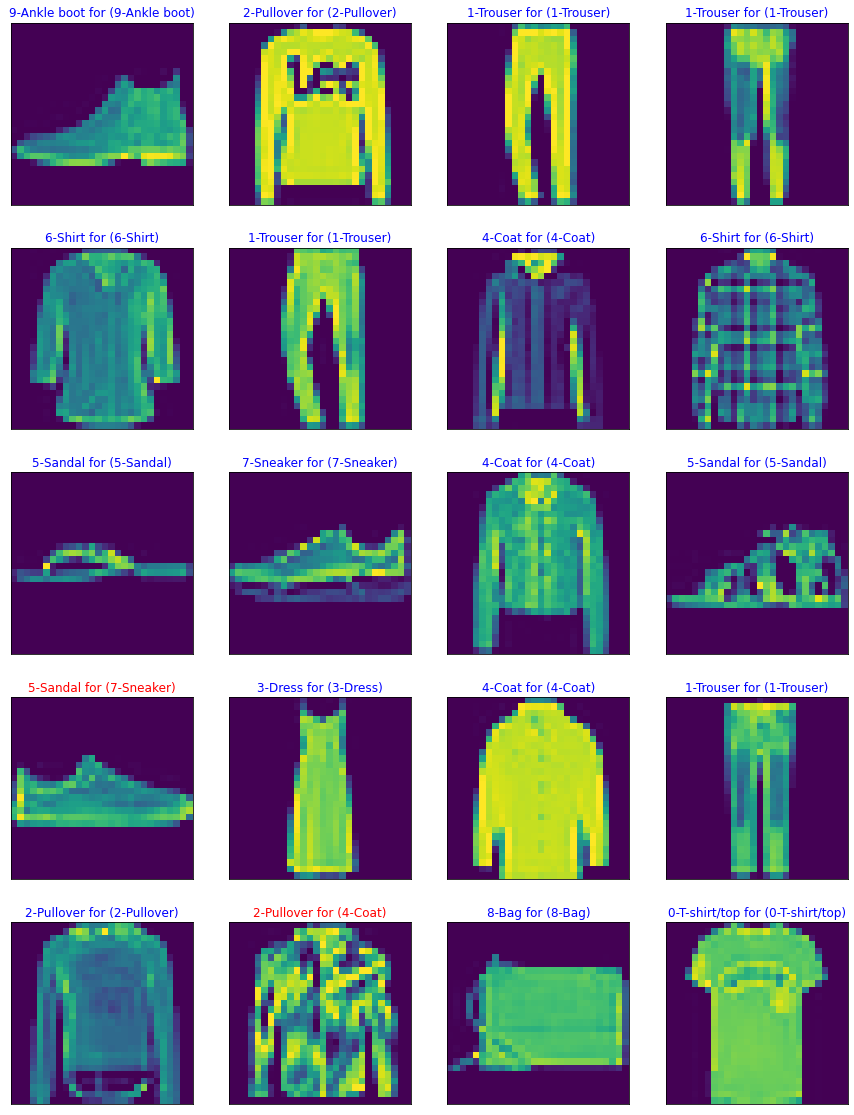

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 20))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(5, batch_size/5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(images[idx]))
    ax.set_title("{}-{} for ({}-{})".format(str(preds[idx].item()), fashion_class[preds[idx].item()],str(labels[idx].item()),fashion_class[labels[idx].item()]),
                 color=("blue" if preds[idx]==labels[idx] else "red"))